In [1]:
import pandas as pd
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import dateutil.easter as easter
from matplotlib.ticker import MaxNLocator
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso

import matplotlib.dates as mdates


In [2]:
original_train_df = pd.read_csv('./datas/train.csv')
original_test_df = pd.read_csv('./datas/test.csv')

gdp_df = pd.read_csv('./datas/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')

gdp_df.set_index('year', inplace=True)

for df in [original_train_df, original_test_df]:
    df['date'] = pd.to_datetime(df.date)
original_train_df.head(2)


,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520


In [3]:
def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200



In [4]:
def engineer(df):   
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]


    #加上gdp信息；增加每周的季节性指示器(Seasonal indicators)   
    new_df = pd.DataFrame({'gdp': np.log(df.apply(get_gdp, axis=1)),
                           'wd2': df.date.dt.weekday == 1, 
                           'wd3': df.date.dt.weekday == 2,
                           'wd4': df.date.dt.weekday == 3,  
                           'wd5': df.date.dt.weekday == 4,
                           'wd6': df.date.dt.weekday == 5,
                           'wd7': df.date.dt.weekday == 6,
                          })

    #将商品种类，国家，商店进行独热编码
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Hat']:
        new_df[product] = df['product'] == product
        
    #添加傅里叶特征：我们对每个产品添加3对傅里叶特征
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'hat_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Hat']
        new_df[f'hat_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Hat']
    
    
    return new_df



In [6]:
train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer(original_test_df)
features = test_df.columns
for df in [train_df, test_df]:
    df[features] = df[features].astype(np.float32)

train_df



,gdp,wd2,wd3,wd4,wd5,wd6,wd7,Finland,Norway,KaggleRama,...,hat_sin1,hat_cos1,sin2,cos2,mug_sin2,mug_cos2,hat_sin2,hat_cos2,date,num_sold
0,5.457200,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000e+00,0.000000,3.442161e-02,0.999407,3.442161e-02,0.999407,0.000000e+00,0.000000,2015-01-01,329.0
1,5.457200,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.721336e-02,0.999852,3.442161e-02,0.999407,0.000000e+00,0.000000,3.442161e-02,0.999407,2015-01-01,520.0
2,5.457200,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000e+00,0.000000,3.442161e-02,0.999407,0.000000e+00,0.000000,0.000000e+00,0.000000,2015-01-01,146.0
3,5.457200,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.000000e+00,0.000000,3.442161e-02,0.999407,3.442161e-02,0.999407,0.000000e+00,0.000000,2015-01-01,572.0
4,5.457200,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.721336e-02,0.999852,3.442161e-02,0.999407,0.000000e+00,0.000000,3.442161e-02,0.999407,2015-01-01,911.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,6.319788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.449294e-16,1.000000,-4.898587e-16,1.000000,-0.000000e+00,0.000000,-4.898587e-16,1.000000,2018-12-31,823.0
26294,6.319788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000000e+00,0.000000,-4.898587e-16,1.000000,-0.000000e+00,0.000000,-0.000000e+00,0.000000,2018-12-31,250.0
26295,6.319788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.000000e+00,0.000000,-4.898587e-16,1.000000,-4.898587e-16,1.000000,-0.000000e+00,0.000000,2018-12-31,1004.0
26296,6.319788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-2.449294e-16,1.000000,-4.898587e-16,1.000000,-0.000000e+00,0.000000,-4.898587e-16,1.000000,2018-12-31,1441.0


In [7]:
list(train_df)

['gdp',
 'wd2',
 'wd3',
 'wd4',
 'wd5',
 'wd6',
 'wd7',
 'Finland',
 'Norway',
 'KaggleRama',
 'Kaggle Mug',
 'Kaggle Hat',
 'sin1',
 'cos1',
 'mug_sin1',
 'mug_cos1',
 'hat_sin1',
 'hat_cos1',
 'sin2',
 'cos2',
 'mug_sin2',
 'mug_cos2',
 'hat_sin2',
 'hat_cos2',
 'date',
 'num_sold']

In [15]:
def fit_model(X_tr):
    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)

    
    model = LinearRegression()

    
    model.fit(X_tr_f, np.log(y_tr).ravel())
        
    return preproc, model


In [16]:

preproc, model = fit_model(train_df)

train_pred_df = original_train_df.copy()

#因为预测的结果是对目标值取对数，所以要获取预测值需要将预测结果进行指数运算来进行还原
train_pred_df['pred'] = np.exp(model.predict(preproc.transform(train_df[features])))
train_pred_df


,row_id,date,country,store,product,num_sold,pred
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,208.362869
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,322.801361
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,92.113159
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,363.336487
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,562.890991
...,...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823,427.414581
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250,122.441978
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004,482.946045
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441,745.312012


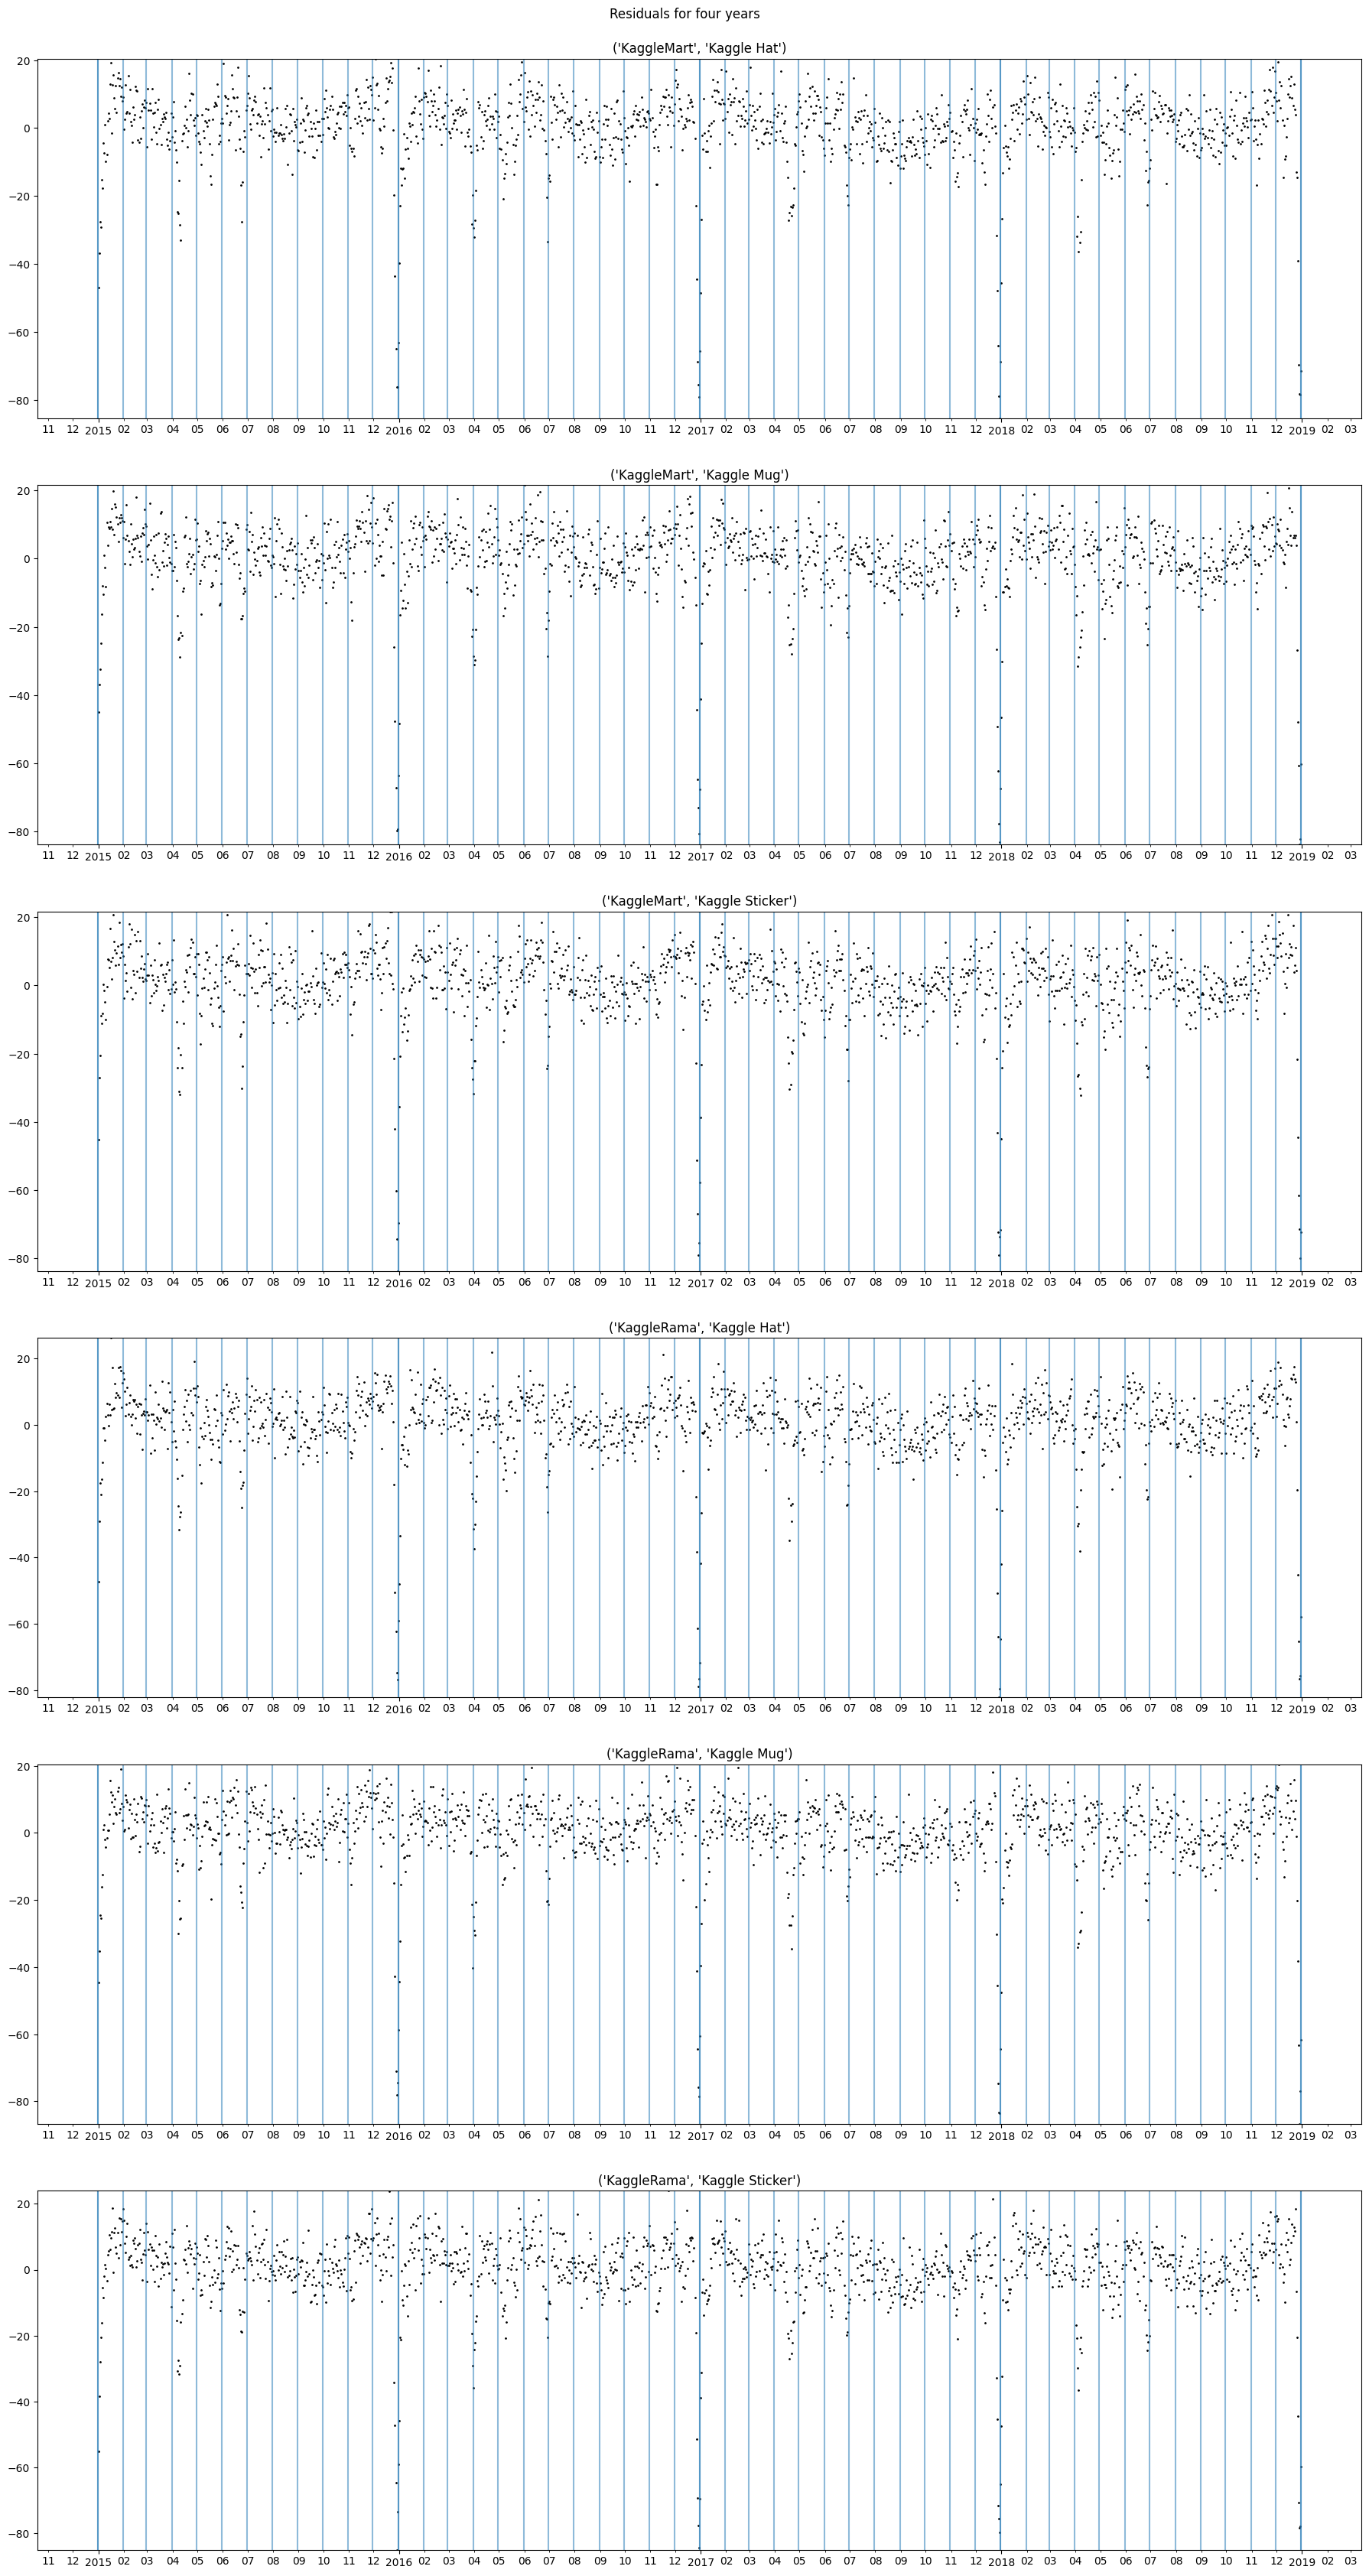

In [17]:
plt.figure(figsize=(18, 100))
for i, (combi, df) in enumerate(train_pred_df[train_pred_df.country == 'Finland'].groupby(['store', 'product'])):
    df = df.set_index('date')
    residuals = (df.pred - df.num_sold) / (df.pred + df.num_sold) * 200
    ax = plt.subplot(18, 1, i+1, ymargin=0.5)
    ax.scatter(df.index,
                residuals,
                s=1, color='k')
    
    ax.set_title(combi)

    ax.vlines(pd.date_range('2014-12-31', '2019-01-01', freq='M'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5)
    ax.vlines(pd.date_range('2014-12-31', '2019-01-01', freq='Y'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5)
    
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
    ax.set_ylim(residuals.min(), residuals.max())
plt.tight_layout(h_pad=3.0)
plt.suptitle('Residuals for four years', y=1.003)
plt.show()


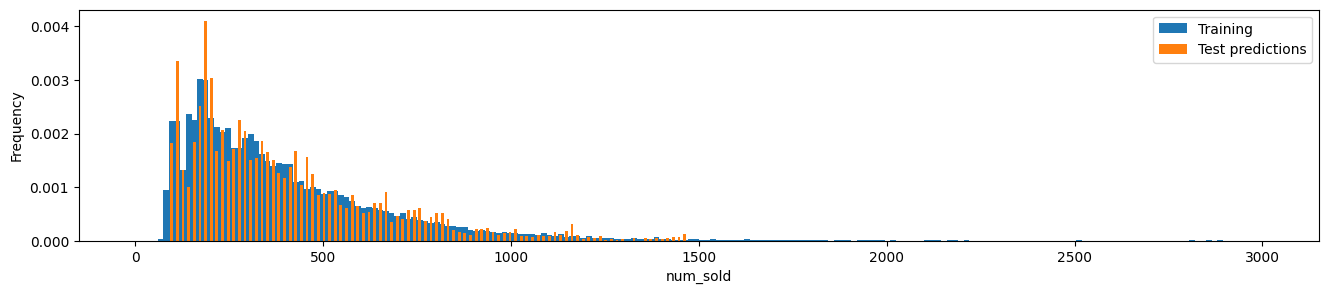

,row_id,num_sold
0,26298,244.362198
1,26299,378.572479
2,26300,108.027771
3,26301,426.111023
4,26302,660.142944
...,...,...
6565,32863,407.129944
6566,32864,116.630997
6567,32865,460.025909
6568,32866,709.940247


In [18]:
# Fit the model on the complete training data
train_idx = np.arange(len(train_df))
X_tr = train_df.iloc[train_idx]
preproc, model = fit_model(X_tr)

LOSS_CORRECTION = 1

# Inference for test
test_pred_list = []
test_pred_list.append(np.exp(model.predict(preproc.transform(test_df[features]))) * LOSS_CORRECTION)

# Create the submission file
sub = original_test_df[['row_id']].copy()
sub['num_sold'] = sum(test_pred_list) / len(test_pred_list)
sub.to_csv('submission_linear_model.csv', index=False)

# Plot the distribution of the test predictions
plt.figure(figsize=(16,3))
plt.hist(train_df['num_sold'], bins=np.linspace(0, 3000, 201),
         density=True, label='Training')
plt.hist(sub['num_sold'], bins=np.linspace(0, 3000, 201),
         density=True, rwidth=0.5, label='Test predictions')
plt.xlabel('num_sold')
plt.ylabel('Frequency')
plt.legend()
plt.show()
sub
